In [1]:
import os
import json
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import multiprocessing

class CustomEncoder(json.JSONEncoder):
    def encode(self, obj):
        parts = []
        for k, v in obj.items():
            if isinstance(v, list):
                # Serialize lists as a single line
                v = json.dumps(v, separators=(',', ':'))
            else:
                v = self.encode(v)
            parts.append(f'{json.dumps(k)}:{v}')
        return '{' + ','.join(parts) + '}'

class CSVDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float), torch.tensor(self.y[idx], dtype=torch.long)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # One commonly used architecture is a simple Feedforward Neural Network (FNN) with two hidden layers.
        # Below is a simple, but usually effective architecture:
        #
        # Input Layer: Number of neurons equal to the number of features in our data.
        # Hidden Layer 1: Number of neurons equal to two-thirds the size of the Input Layer plus the size of the Output Layer.
        # Hidden Layer 2: Number of neurons equal to the size of the Input Layer.
        # Output Layer: Number of neurons equal to the number of classes in our output.

        # Define sizes for the layers
        self.input_size = INPUT_SIZE
        self.hidden_size1 = int((2/3) * self.input_size + NUM_CLASSES)
        self.hidden_size2 = self.input_size
        self.output_size = NUM_CLASSES

        # Define layers
        self.fc1 = nn.Linear(self.input_size, self.hidden_size1)
        self.fc2 = nn.Linear(self.hidden_size1, self.hidden_size2)
        self.fc3 = nn.Linear(self.hidden_size2, self.output_size)

    # For all hidden layers, use ReLU as the activation function. For the output layer, use softmax for multi-class classification tasks.
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # We do not explicitly include the softmax activation function at the output layer of the neural network.
        # However, the PyTorch CrossEntropyLoss function, which we used as the criterion in our model,
        # combines both a Log Softmax operation and the negative log-likelihood loss.
        # Therefore, while we do not explicitly include a softmax function in our model's architecture,
        # it is included as part of the loss computation.
        x = self.fc3(x)
        return x

def main():
    
    # Load data
    print("Loading data...")
    df = pd.read_csv(CSV_FILE)

    # Split data
    print("Splitting data...")
    train_df, test_df = train_test_split(df, test_size=SPLIT_RATE, random_state=42, stratify=df['application_name'])

    # Standardize the feature columns
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df.drop('application_name', axis=1))
    X_test = scaler.transform(test_df.drop('application_name', axis=1))

    y_train = train_df['application_name'].values
    y_test = test_df['application_name'].values

    # Load datasets into PyTorch Dataset class
    train_data = CSVDataset(X_train, y_train)
    test_data = CSVDataset(X_test, y_test)

    # Create DataLoaders
    train_loader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, num_workers=WORKERS)  # Adjust batch size and num_workers
    test_loader = DataLoader(test_data, batch_size=TEST_BATCH_SIZE, num_workers=WORKERS)  # Adjust batch size and num_workers

    # Check if a GPU is available and if not, use a CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define model, loss function and optimizer
    print("Initializing model...")
    model = Net().to(device)  # Move model to GPU if available
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Initialize metrics
    train_metrics = {
        "accuracy": [],
        "loss": []
    }   
    val_metrics = {
        "accuracy": [],
        "loss": [],
        "precision": [],
        "recall": [],
        "f1_score": [],
        "confusion_matrix": []
    }

    # Ensure directory exists
    if not os.path.exists("fig"):
        os.makedirs("fig")

    # Train model for 100 epochs
    print("Starting training...")
    for epoch in range(NUM_EPOCHS):  # Number of epochs
        start_time = time.time()
        train_loss = 0
        train_correct = 0
        total_train_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(output, 1)
            train_correct += torch.sum(preds == labels.data)
            total_train_samples += labels.size(0)

        # Calculate training accuracy and loss descibing the model's performance on the training set. 
        # They show how well the model is learning the patterns in the training data.
        train_accuracy = train_correct.double() / total_train_samples
        train_loss = train_loss / total_train_samples

        # Store training metrics
        train_metrics["accuracy"].append(train_accuracy.item())
        train_metrics["loss"].append(train_loss)

        # Metrics calculation for validation set
        model.eval()
        all_preds = []
        all_labels = []
        val_loss = 0
        val_correct = 0
        total_val_samples = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
                output = model(inputs)
                loss = criterion(output, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(output, 1)
                val_correct += torch.sum(preds == labels.data)
                total_val_samples += labels.size(0)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate validation accuracy and loss describing the model's performance on the validation set.
        # They give an indication of how well the model is likely to generalize to unseen data. 
        val_accuracy = val_correct.double() / total_val_samples
        val_loss = val_loss / total_val_samples

        # Store metrics
        # In a multi-class setting, accuracy is still calculated as the number of correct predictions 
        # divided by the total number of predictions. Each sample is assigned to the class with the highest
        # predicted probability.
        val_metrics["accuracy"].append(val_accuracy.item())
        val_metrics["loss"].append(val_loss)
        # Precision, Recall, and F1 score: For multi-class problems, these are typically calculated in one of the following ways:
            # Micro-average: This method aggregates the contributions of all classes to compute the average metric. It calculates metrics globally by counting the total true positives, false negatives, and false positives. This approach is useful when the dataset is class-imbalanced because it gives equal weight to each observation.
            # Macro-average: This method calculates metrics for each label and finds their unweighted mean. This approach treats all classes equally, no matter what their prevalence is. It calculates the metrics independently for each class and then takes the average (hence treating all classes equally).
            # Weighted-average: This method calculates metrics for each label and finds their average weighted by support (the number of true instances for each label). This can alter the metric to favor the majority class.
        val_metrics["precision"].append(precision_score(all_labels, all_preds, average='macro'))
        val_metrics["recall"].append(recall_score(all_labels, all_preds, average='macro'))
        val_metrics["f1_score"].append(f1_score(all_labels, all_preds, average='macro'))

        # Store confusion matrix
        cm = confusion_matrix(all_labels, all_preds, normalize='true').tolist()  # tolist() for json serializable
        val_metrics["confusion_matrix"].append(cm)

        model.train()

        end_time = time.time()

#         print(f"Epoch {epoch + 1} finished. Time elapsed {end_time - start_time}s")
    print("Training finished.")

    # Add the new metrics to the file
    with open("fig/cl_results.json", 'w') as outfile:
        json.dump({"train_metrics": train_metrics, "val_metrics": val_metrics}, outfile, indent=4)

    print("Done.")

if __name__ == '__main__':
    
    # Adjust these to your dataset
    CSV_FILE = "dataset_cl.csv"
    INPUT_SIZE = 18  # Number of input features
    NUM_CLASSES = 10  # Number of classes in 'application_name'
    NUM_EPOCHS = 100  # Change this to the total number of epochs you want
    SPLIT_RATE = 0.1667
    TRAIN_BATCH_SIZE = 32
    TEST_BATCH_SIZE = 32
    
    WORKERS = 0
#     WORKERS = multiprocessing.cpu_count()
    
    main()

Loading data...
Splitting data...
Initializing model...
Starting training...
Training finished.
Done.


## Remove spaces and new line characters within the brackets for simpler data handling

In [2]:
# Linux:
# !sed -i ':a;N;$!ba;s/\n\+\([ ]\)*\([0-9]\)/\2/g;s/\n\+\([ ]\)*\]/\]/g;s/\[\ \]/\[/g' cl_results.json

# MacOS:
!sed -i '' -e ':a' -e 'N' -e '$!ba' -e 's/\n\{1,\}[ ]*\([0-9]\)/\1/g' -e 's/\n\{1,\}[ ]*\]/\]/g' -e 's/\[[ ]\]/\[/g' cl_results.json

## Plot the training versus validaiton accuracy and loss

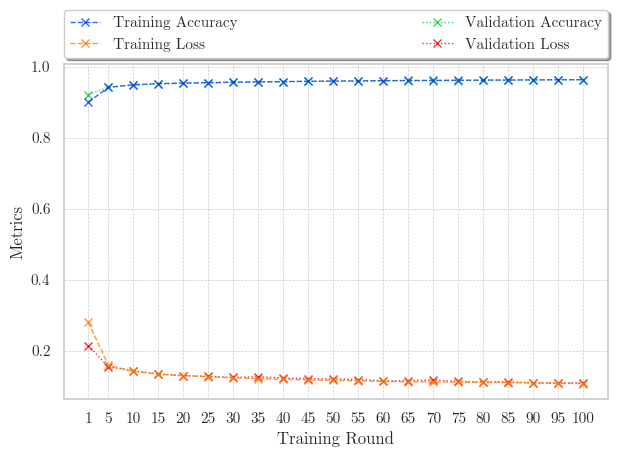

<Figure size 640x480 with 0 Axes>

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D

def plot_metrics(rounds, metrics, filename):

    # Initialize list for lines and labels
    lines = []
    labels = []

    linestyles = ['--', '--', ':', ':']

    for i, (metric, values) in enumerate(metrics.items()):
        line, = plt.plot(rounds
                         , values
                         , marker='x'
                         , color=color_palette[i]
#                          , markersize=6
#                          , markeredgewidth=2
#                          , markerfacecolor='white'
#                          , markeredgecolor=color_palette[i]
                         , linestyle=linestyles[i % len(linestyles)] # adding linestyles
                         , alpha=0.8  # reducing alpha
                         , zorder=len(metrics)-i  # setting zorder
                         , linewidth=1.0
                        )
        lines.append(line)
        labels.append(f'{metric}')

    # Add title and labels
    plt.xlabel('Training Round')
    plt.ylabel('Metrics')

    # Add a legend
    plt.legend(lines, labels,
               bbox_to_anchor=(0., 1.02, 1., .102),
               loc='lower left',
               ncol=2,
               mode="expand",
               borderaxespad=0.,
               fancybox=True,
               shadow=True)

    plt.grid(linestyle='--', linewidth=0.5)

    # Set x ticks
    plt.xticks(rounds)

    # Show the plot
    plt.tight_layout()

    # Save the plot
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()

    # Clear the current plot to make ready for the next plot
    plt.clf()

# Set the font and color palette
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'CMU Serif'
plt.rcParams['font.size'] = '14'
color_palette = sns.color_palette("bright")

metrics = {
"Training Accuracy"    : [0.8996677266005767,0.9268398558678106,0.9338752995401464,0.9382912006663114,0.9413130710673334,0.9431050181576913,0.9444593454761057,0.9460465994473286,0.9473356367191222,0.9486052634365152,0.9494055076565814,0.9501095814025714,0.9507474828040134,0.9513800904178916,0.9518327092545994,0.9521035747182822,0.952645305645648,0.9527167717777597,0.9530820431196643,0.9532673256843985,0.9534755479952427,0.9537984690366366,0.9539943391764985,0.9542510878733443,0.9544990135909173,0.9547037067100522,0.9550389799224284,0.9553407258135669,0.9554871872694997,0.955765111116601,0.9559371592124256,0.956189496419635,0.9564021302201157,0.956521240440302,0.9567629900723837,0.956902393144898,0.9570656182614495,0.957309132489386,0.9573558942795332,0.9575958793157603,0.9577846910722038,0.9578438050333332,0.9580440866628316,0.9581614322871632,0.9583970058337539,0.9585161160539402,0.958636990869981,0.9586325793803445,0.958873446714499,0.9590287311497048,0.959150488263673,0.959202543841384,0.9593648866600083,0.9595237002869232,0.9596163415692904,0.9597645676210778,0.959860738095154,0.9600548436391613,0.9600813125769805,0.9601907175199664,0.9603115923360073,0.960353942636518,0.9605145208592876,0.9606424540587469,0.9607068618074402,0.9608056791752985,0.9607845040250431,0.9609750803773411,0.9610156660819973,0.9610006670172331,0.96118506728404,0.961225652988696,0.9611912433695311,0.961277708566407,0.9613262349524089,0.9613800551259745,0.9615397510508168,0.9615353395611803,0.9615212227943434,0.9617038584652957,0.9617620901284979,0.9618450261336646,0.9618979640093029,0.9619976636750885,0.9619800177165424,0.9621335375558936,0.9621494189185851,0.962247353988516,0.9622897042890267,0.9623011741620816,0.9625093964729258,0.9625852740946741,0.9625261601335446,0.9625561582630731,0.9626496818433674,0.9627634982759898,0.9628182007474828,0.9628526103666477,0.9628843730920308,0.9630017187163624],
"Training Loss"        : [0.2799716906539231,0.19603167717473208,0.17557239701931043,0.16490721932640964,0.15915371490251579,0.15487878819147435,0.1517841460002363,0.1484404964012169,0.14537657857648992,0.1424763019552214,0.14034466620503144,0.13869527199233997,0.13697760427354344,0.13524569658057706,0.13407870235434508,0.13318682346059554,0.13218506329491592,0.13141872609420163,0.1303796999858447,0.1300836817577598,0.1289250344541497,0.12820195840595516,0.12764545255285237,0.12749291058388382,0.12706636493337836,0.12611439984333628,0.1258569465518855,0.12488105414622662,0.12442989356813554,0.12391714238012137,0.12330418692235631,0.12269243325943764,0.12279022009411242,0.12181708900148382,0.12141087024782019,0.12116383053987062,0.12080406371644178,0.12060578963404087,0.1203244199157967,0.11969341680156517,0.11962685616545693,0.11900243414917051,0.11898551096303031,0.11847263216004988,0.11814568378863147,0.11831285099990001,0.11800140603031513,0.11817562921417195,0.11751703753332081,0.11686522596109007,0.11681079718257709,0.11637418152657966,0.1160026296261955,0.11550922378717339,0.1153511473684452,0.11480893842847376,0.11447509337367626,0.11483851685985419,0.11418173562163715,0.11391679704770265,0.113725080310296,0.11345783347201956,0.11353085274510188,0.1132343145737086,0.11272188914111858,0.11270619222335085,0.11257422817550149,0.11238725686465822,0.11249341666072021,0.11232783277727579,0.11230510522168366,0.11210373308486468,0.11162694915712015,0.11167582701809918,0.11169659438830785,0.11136372992715309,0.11095181683405388,0.11165136670735124,0.11077762794592547,0.11113077088295437,0.11021619533399618,0.11001710143304738,0.10993028487458115,0.10955427862795515,0.11075037745378179,0.10922416801286038,0.1092529774995456,0.10980095968992512,0.1087137595996952,0.10944106176325531,0.10893554901343924,0.10860062476622272,0.10877994855157073,0.10851524815148231,0.10853151721179663,0.10843848954930058,0.10762691781160777,0.10812532170267916,0.10789301366883872,0.10755584923828965],   
"Validation Accuracy"  : [0.9210447392562275,0.9317841013337097,0.9368163855761767,0.9398154682097241,0.941681074024416,0.9424440759297156,0.9451211982217204,0.9466913061886952,0.9483584432996965,0.9481423329334556,0.9499373720979465,0.949716851316068,0.9488744619292923,0.9500299908263354,0.9504533907275422,0.9502284595300261,0.9514589654929081,0.9510223343447887,0.9520587820196176,0.9530423047067955,0.9531525650977348,0.9532495942417614,0.9534921671018277,0.9530511255380707,0.9544007127231671,0.9548152917930985,0.9555518312045728,0.9553489520852445,0.9557811728177263,0.9560237456777927,0.9561781102251076,0.9559311269494037,0.956111953990544,0.9564118622538988,0.9563765789287982,0.9562266247971208,0.956266318537859,0.9565706372168513,0.957558570319667,0.9569411121304072,0.9584053701220803,0.9572542516406746,0.957404205772352,0.95822454308094,0.9581804389245643,0.9585068096817444,0.9576114953073178,0.9583700867969798,0.9572718933032249,0.9582333639122151,0.9579025827393973,0.9580613577023499,0.9583083409780537,0.958480347187919,0.9584230117846306,0.9590713428833533,0.9583215722249665,0.9587140992167101,0.9600151718297932,0.9601077905581822,0.9601122009738198,0.9600901488956319,0.9600989697269071,0.9599622468421424,0.9597858302166397,0.9598343447886529,0.9600504551548938,0.9603812363277116,0.9600107614141556,0.9600151718297932,0.9596711594100628,0.9602489238585844,0.9604385717309999,0.9606502716816033,0.9605620633688519,0.9600372239079811,0.9604606238091877,0.960826688307106,0.9602930280149601,0.9611177757391857,0.9606193987721403,0.960950179944958,0.9617043610189824,0.9612192152988498,0.961483840237104,0.9618499047350222,0.9612721402865007,0.9616823089407945,0.9620527838543504,0.962312998376967,0.9627981440970997,0.9629348669818644,0.9630230752946157,0.9620351421918002,0.9628554795003881,0.9628378378378378,0.9625423399901206,0.9622512525580411,0.9618322630724719,0.9625952649777715],
"Validation Loss"      : [0.21439142521647178,0.1824418762577187,0.16677634160433083,0.16112545886343876,0.15476418980088727,0.154554029553432,0.14886774239506567,0.14745121731829453,0.1433074463649251,0.14362230445766666,0.1390900456442326,0.13716919577264058,0.13822223889828045,0.1357727873487204,0.13511253414602906,0.1368475320393635,0.13374907465894928,0.13241828522810487,0.13096857350575933,0.13007704916974488,0.12920513580852327,0.12989815599295254,0.12925607853006327,0.13228924278763718,0.12781758718243838,0.12833201396671715,0.12536647564203607,0.12554817650566788,0.12540268867075702,0.1251183883484502,0.12483240673015535,0.12596926948467824,0.12561233020650142,0.12503745299235916,0.12675796722794516,0.12478236989151348,0.12625815006688412,0.12515597911740212,0.12121254060892309,0.12343636691291233,0.1198145353682071,0.12279661728074312,0.12220445413628248,0.12103732016116195,0.12166080013921463,0.1204377572257491,0.12222243881852136,0.11988996355408921,0.12224981796503,0.12064494115385453,0.12130928741364874,0.12097658901496072,0.11904669459541167,0.11941964068328385,0.11884077410042448,0.11727073316130253,0.11910332217300577,0.11886630982901762,0.11616618307049081,0.11571297196124705,0.11467756746053169,0.11636425098903105,0.11485907347430818,0.11615938358969036,0.11620848381868976,0.11727292447121358,0.11674190409824323,0.11532268062892836,0.11740962510850173,0.11739737574244,0.11666146220398681,0.11466670028813944,0.11461518582671136,0.11400543740980033,0.11392913732315448,0.1161406201623416,0.1138536328260308,0.11668255709609325,0.11429651311468132,0.11271753846432099,0.11408342022668153,0.11327657604534327,0.11194777089418154,0.11286678138935535,0.11254405177454463,0.1121698888891493,0.11635559167975545,0.11236111988891768,0.11151132381210112,0.11005239173420713,0.10958144867499087,0.1089325990535689,0.11014562663076394,0.11217783079573637,0.1094911392930235,0.10905413510851343,0.10911129482536583,0.10938399274881543,0.11113561229762177,0.10944428849583104]
}

# Training rounds
n = 5

# Create a list of all rounds
all_rounds = np.arange(1, 101)

# Select specific rounds: 1, n, 2n, 3n, ..., 100
rounds = np.append(all_rounds[0], all_rounds[n-1::n])

# Update values to match new rounds
metrics = {key: np.append(values[0], values[n-1::n]) for key, values in metrics.items()}

plot_metrics(rounds, metrics, 'cl-acc-loss-metrics.png')

## Plot the validaiton accuracy along with the macro-averaged precision, recall, and f1-score

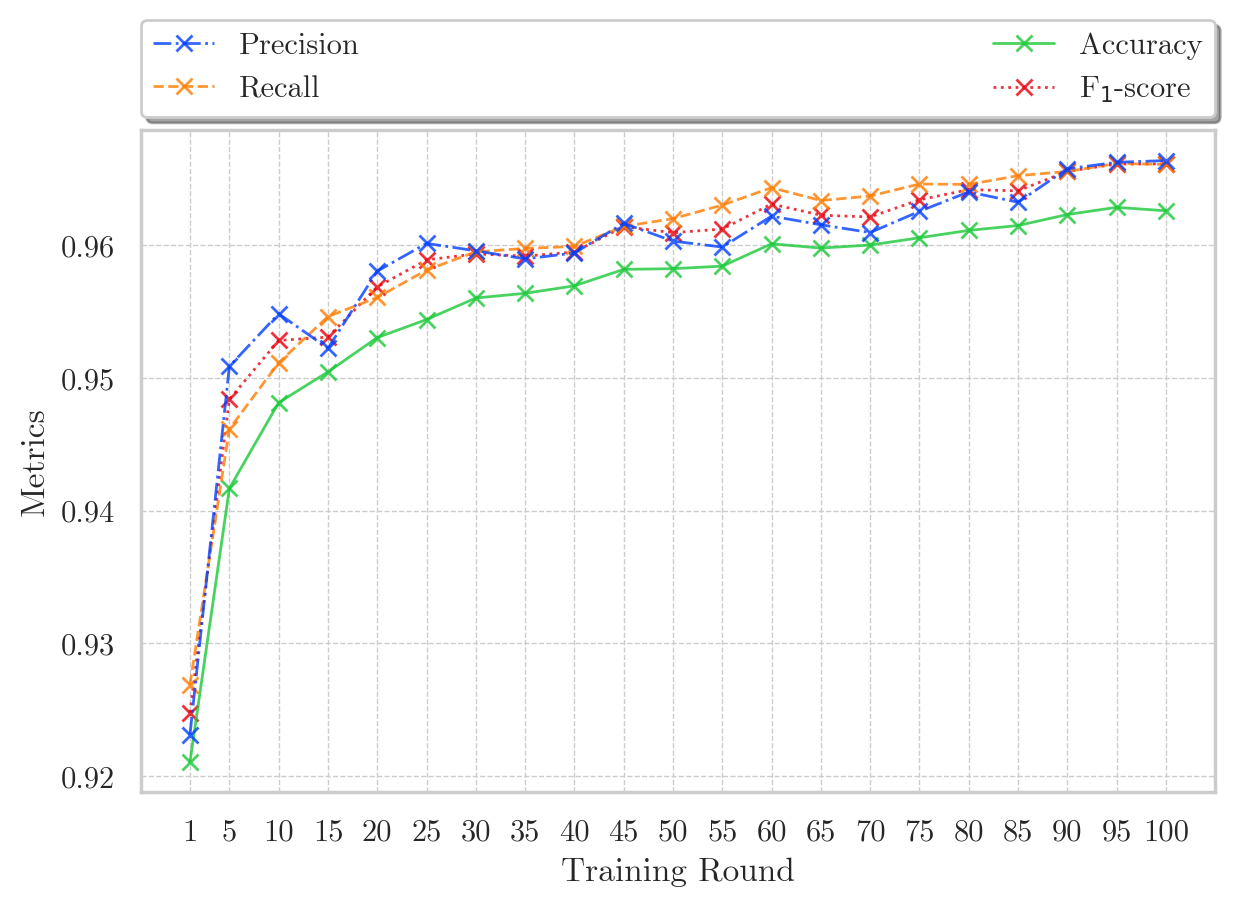

<Figure size 640x480 with 0 Axes>

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D

def plot_metrics(rounds, metrics, filename):

    # Initialize list for lines and labels
    lines = []
    labels = []

    linestyles = ['-.', '--', '-', ':']
    for i, (metric, values) in enumerate(metrics.items()):
        line, = plt.plot(rounds
                         , values
                         , marker='x'
                         , color=color_palette[i]
#                          , markersize=6
#                          , markeredgewidth=2
#                          , markerfacecolor='white'
#                          , markeredgecolor=color_palette[i]
                         , linestyle=linestyles[i % len(linestyles)] # adding linestyles
                         , alpha=0.8  # reducing alpha
                         , zorder=len(metrics)-i  # setting zorder
                         , linewidth=1.0  # setting linewidth
                        )
        lines.append(line)
        if metric == "f1_score":
            labels.append('F$_1$-score')
        else:
            labels.append(metric.replace("_", "\_"))
#         labels.append(f'{metric}')

    # Add title and labels
    plt.xlabel('Training Round')
    plt.ylabel('Metrics')

    # Add a legend
    plt.legend(lines, labels,
               bbox_to_anchor=(0., 1.02, 1., .102),
               loc='lower left',
               ncol=2,
               mode="expand",
               borderaxespad=0.,
               fancybox=True,
               shadow=True)

    plt.grid(linestyle='--', linewidth=0.5)

    # Set x ticks
    plt.xticks(rounds)

    # Show the plot
    plt.tight_layout()

    # Save the plot
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()

    # Clear the current plot to make ready for the next plot
    plt.clf()

# Set the font and color palette
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'CMU Serif'
plt.rcParams['font.size'] = '14'
color_palette = sns.color_palette("bright")

# Client Data
metrics = {
        "Precision": [0.9231134563096338,0.9411722920721302,0.9445184948345234,0.9493429038493282,0.9508729506299594,0.9517576111178961,0.9530050546067741,0.9536395165017961,0.9546363803004381,0.9548400418201213,0.9557091636407682,0.9539415277664258,0.9508141133881057,0.9521879466636534,0.9522337412575178,0.9515996836785592,0.9556128154508201,0.9531603231679989,0.9564692515248,0.9580469017985347,0.9585084529983531,0.9588040343754247,0.9576873729801175,0.9588381864237092,0.9601380317942081,0.9599766946476231,0.9601963293501523,0.9598317821143935,0.9598452755466328,0.9595805180152264,0.9591796361628283,0.9588639548212381,0.9587431982089312,0.9589520318094358,0.9589715026381626,0.958402312158713,0.9587997943696538,0.9582693354472406,0.9610516641518785,0.9594130846338411,0.9625784648234286,0.9610189952064065,0.9602410187305088,0.9617647865987999,0.9616510306323015,0.9625832625835656,0.9600362707620361,0.9625300836361184,0.9589422066403566,0.9603093249871334,0.9598311838091137,0.9601985441223088,0.9602743640524822,0.9602181377559837,0.959861880953653,0.9607990403970806,0.9588332189903029,0.9597109646402219,0.9615148207030717,0.9621899389831094,0.9622384890377343,0.9618184334600073,0.962073568979059,0.9613932878671273,0.9615430786140925,0.961605360174118,0.9614904166792411,0.9620195794285348,0.9614372230104282,0.9609535352113167,0.9602691003238423,0.9617903000572549,0.9623808401132221,0.9630785845445733,0.962550459587235,0.9609511361049892,0.9631288276837806,0.9643685418239679,0.9625783834881754,0.9640177735189506,0.9624406098979351,0.9633649303084966,0.9645531650321025,0.9634864324222876,0.963239042830508,0.9642522246595453,0.9649080939753037,0.9642376870439759,0.9649530839777342,0.965757136209691,0.9661157531049239,0.9667843477145505,0.9664742431793119,0.964337342803194,0.9662499976449901,0.9659590623175648,0.9662109380962933,0.964331773286913,0.9644466972371462,0.966378499534982],
        "Recall": [0.9268904212083191,0.9363602038459813,0.9414045096367593,0.9436934453277269,0.9461585539399657,0.9465039469883898,0.9487328661351777,0.9494697782569513,0.9515027616764462,0.9511402390040926,0.953420104428434,0.95351663638168,0.9537307741811208,0.954909032903027,0.9546280988396928,0.9545719907012888,0.9550724808369425,0.9557508731281914,0.9562341938202389,0.9560616703789183,0.9564628888656461,0.9564277415851015,0.9576772608222412,0.9557573380315072,0.9581283673219989,0.957402852299811,0.9593824797679327,0.9584709537649141,0.9588631541661551,0.9595042121095618,0.9596981732420824,0.9589790926608226,0.9595816214733723,0.9599929142616643,0.959757360321088,0.9601058261498574,0.9601790713834258,0.9601199391690581,0.9606659934982146,0.9599113753461161,0.9616328089837769,0.9605236795421073,0.9611998243579922,0.9616546184306444,0.9614249290053338,0.9618371109285835,0.9610517547462051,0.9612211579979766,0.9608802953995392,0.96200256106269,0.9618010485425916,0.9620898766794006,0.9624536363890526,0.9627082721140228,0.963023672671194,0.9633564133693749,0.962920667576755,0.9631554085234836,0.963993786366054,0.9643354493245291,0.9643990046692368,0.9636822716978749,0.963766928821066,0.9639077921480892,0.9633676467045559,0.9633888957531825,0.9633358396934728,0.9638679115973433,0.9634853314996373,0.9637087716610042,0.9635979909828635,0.9644897780015175,0.9641046673351917,0.9638048449329185,0.9646120503466076,0.9638266497728329,0.9638170380082881,0.9634561146943005,0.9634869552616369,0.9645833539190664,0.964604736784875,0.964668009752981,0.9651926955263062,0.9644337633893899,0.9652386214835573,0.9652159755222925,0.9638458946308657,0.9646858224819033,0.9652363535967214,0.96555808227978,0.9664251719383617,0.9663793623752165,0.9662863892925164,0.9656135496013525,0.966165645156407,0.9663380920150295,0.9662058089348559,0.9659836749278984,0.9653207645520367,0.9660855749427466],
        "Accuracy": [0.9210447392562275,0.9317841013337097,0.9368163855761767,0.9398154682097241,0.941681074024416,0.9424440759297156,0.9451211982217204,0.9466913061886952,0.9483584432996965,0.9481423329334556,0.9499373720979465,0.949716851316068,0.9488744619292923,0.9500299908263354,0.9504533907275422,0.9502284595300261,0.9514589654929081,0.9510223343447887,0.9520587820196176,0.9530423047067955,0.9531525650977348,0.9532495942417614,0.9534921671018277,0.9530511255380707,0.9544007127231671,0.9548152917930985,0.9555518312045728,0.9553489520852445,0.9557811728177263,0.9560237456777927,0.9561781102251076,0.9559311269494037,0.956111953990544,0.9564118622538988,0.9563765789287982,0.9562266247971208,0.956266318537859,0.9565706372168513,0.957558570319667,0.9569411121304072,0.9584053701220803,0.9572542516406746,0.957404205772352,0.95822454308094,0.9581804389245643,0.9585068096817444,0.9576114953073178,0.9583700867969798,0.9572718933032249,0.9582333639122151,0.9579025827393973,0.9580613577023499,0.9583083409780537,0.958480347187919,0.9584230117846306,0.9590713428833533,0.9583215722249665,0.9587140992167101,0.9600151718297932,0.9601077905581822,0.9601122009738198,0.9600901488956319,0.9600989697269071,0.9599622468421424,0.9597858302166397,0.9598343447886529,0.9600504551548938,0.9603812363277116,0.9600107614141556,0.9600151718297932,0.9596711594100628,0.9602489238585844,0.9604385717309999,0.9606502716816033,0.9605620633688519,0.9600372239079811,0.9604606238091877,0.960826688307106,0.9602930280149601,0.9611177757391857,0.9606193987721403,0.960950179944958,0.9617043610189824,0.9612192152988498,0.961483840237104,0.9618499047350222,0.9612721402865007,0.9616823089407945,0.9620527838543504,0.962312998376967,0.9627981440970997,0.9629348669818644,0.9630230752946157,0.9620351421918002,0.9628554795003881,0.9628378378378378,0.9625423399901206,0.9622512525580411,0.9618322630724719,0.9625952649777715],
        "f1_score": [0.924785861776166,0.9386555188275567,0.9428054947206175,0.946355758761538,0.9483925749749387,0.9489607476448612,0.9507292760944461,0.9514028460570014,0.9529223415792731,0.9528266661914169,0.9544324988091404,0.9535255060733926,0.951910783849556,0.9532322465156773,0.9530774991173109,0.9526581410667679,0.9550850337734967,0.9541004027256859,0.956133008538151,0.9568639899314295,0.9572789687526075,0.9574028461839885,0.9574599545704642,0.9570235835470754,0.9588983173095784,0.9584444784153417,0.9596083093875339,0.9589609918146763,0.9591726047695177,0.9593458863517131,0.9592323843146208,0.958718193943499,0.9589325772838725,0.9592705417244325,0.9591806463944698,0.9590015302100001,0.9593314979638305,0.9589793183744926,0.9607077485355289,0.959488809492988,0.9619957332216776,0.9606058642803527,0.9605279828910088,0.9615587113806182,0.9614059224075573,0.9620631074079959,0.9603589469227003,0.9617454543516635,0.9597031794509668,0.9609439616888189,0.9605920309296163,0.960922907661752,0.961147204256563,0.9612439157375208,0.9612191303618957,0.9618844710860881,0.9605997624918402,0.961202303949358,0.9626067865957687,0.9631053401981386,0.9631647938062985,0.962573167949573,0.9627856803225384,0.9624638664513187,0.9622624746227496,0.9623096406094813,0.9622328989307036,0.9627784483287092,0.9622747712508956,0.9621276690935547,0.9616951115696679,0.9629377985554145,0.9630703094299007,0.963290938943041,0.9634223890831951,0.9622041617402626,0.9633001723600649,0.9637428027916645,0.962860544200764,0.9641900909258704,0.9633603341015909,0.9638860623818666,0.9647415616786539,0.96379398139865,0.9640993678773484,0.9645925372674666,0.9642010175437342,0.9643137692947068,0.9649707568652456,0.9655639527246741,0.9661705020020307,0.9665046322381501,0.9662929288634491,0.9648469942464988,0.9661157558885473,0.9660483951530686,0.966106135304449,0.9650314818245975,0.9647332475683298,0.966131372234261]
}

# Training rounds
n = 5

# Create a list of all rounds
all_rounds = np.arange(1, 101)

# Select specific rounds: 1, n, 2n, 3n, ..., 100
rounds = np.append(all_rounds[0], all_rounds[n-1::n])

# Update values to match new rounds
metrics = {key: np.append(values[0], values[n-1::n]) for key, values in metrics.items()}

plot_metrics(rounds, metrics, 'cl-perf-metrics.png')

## Plot the normalized confusion matrix

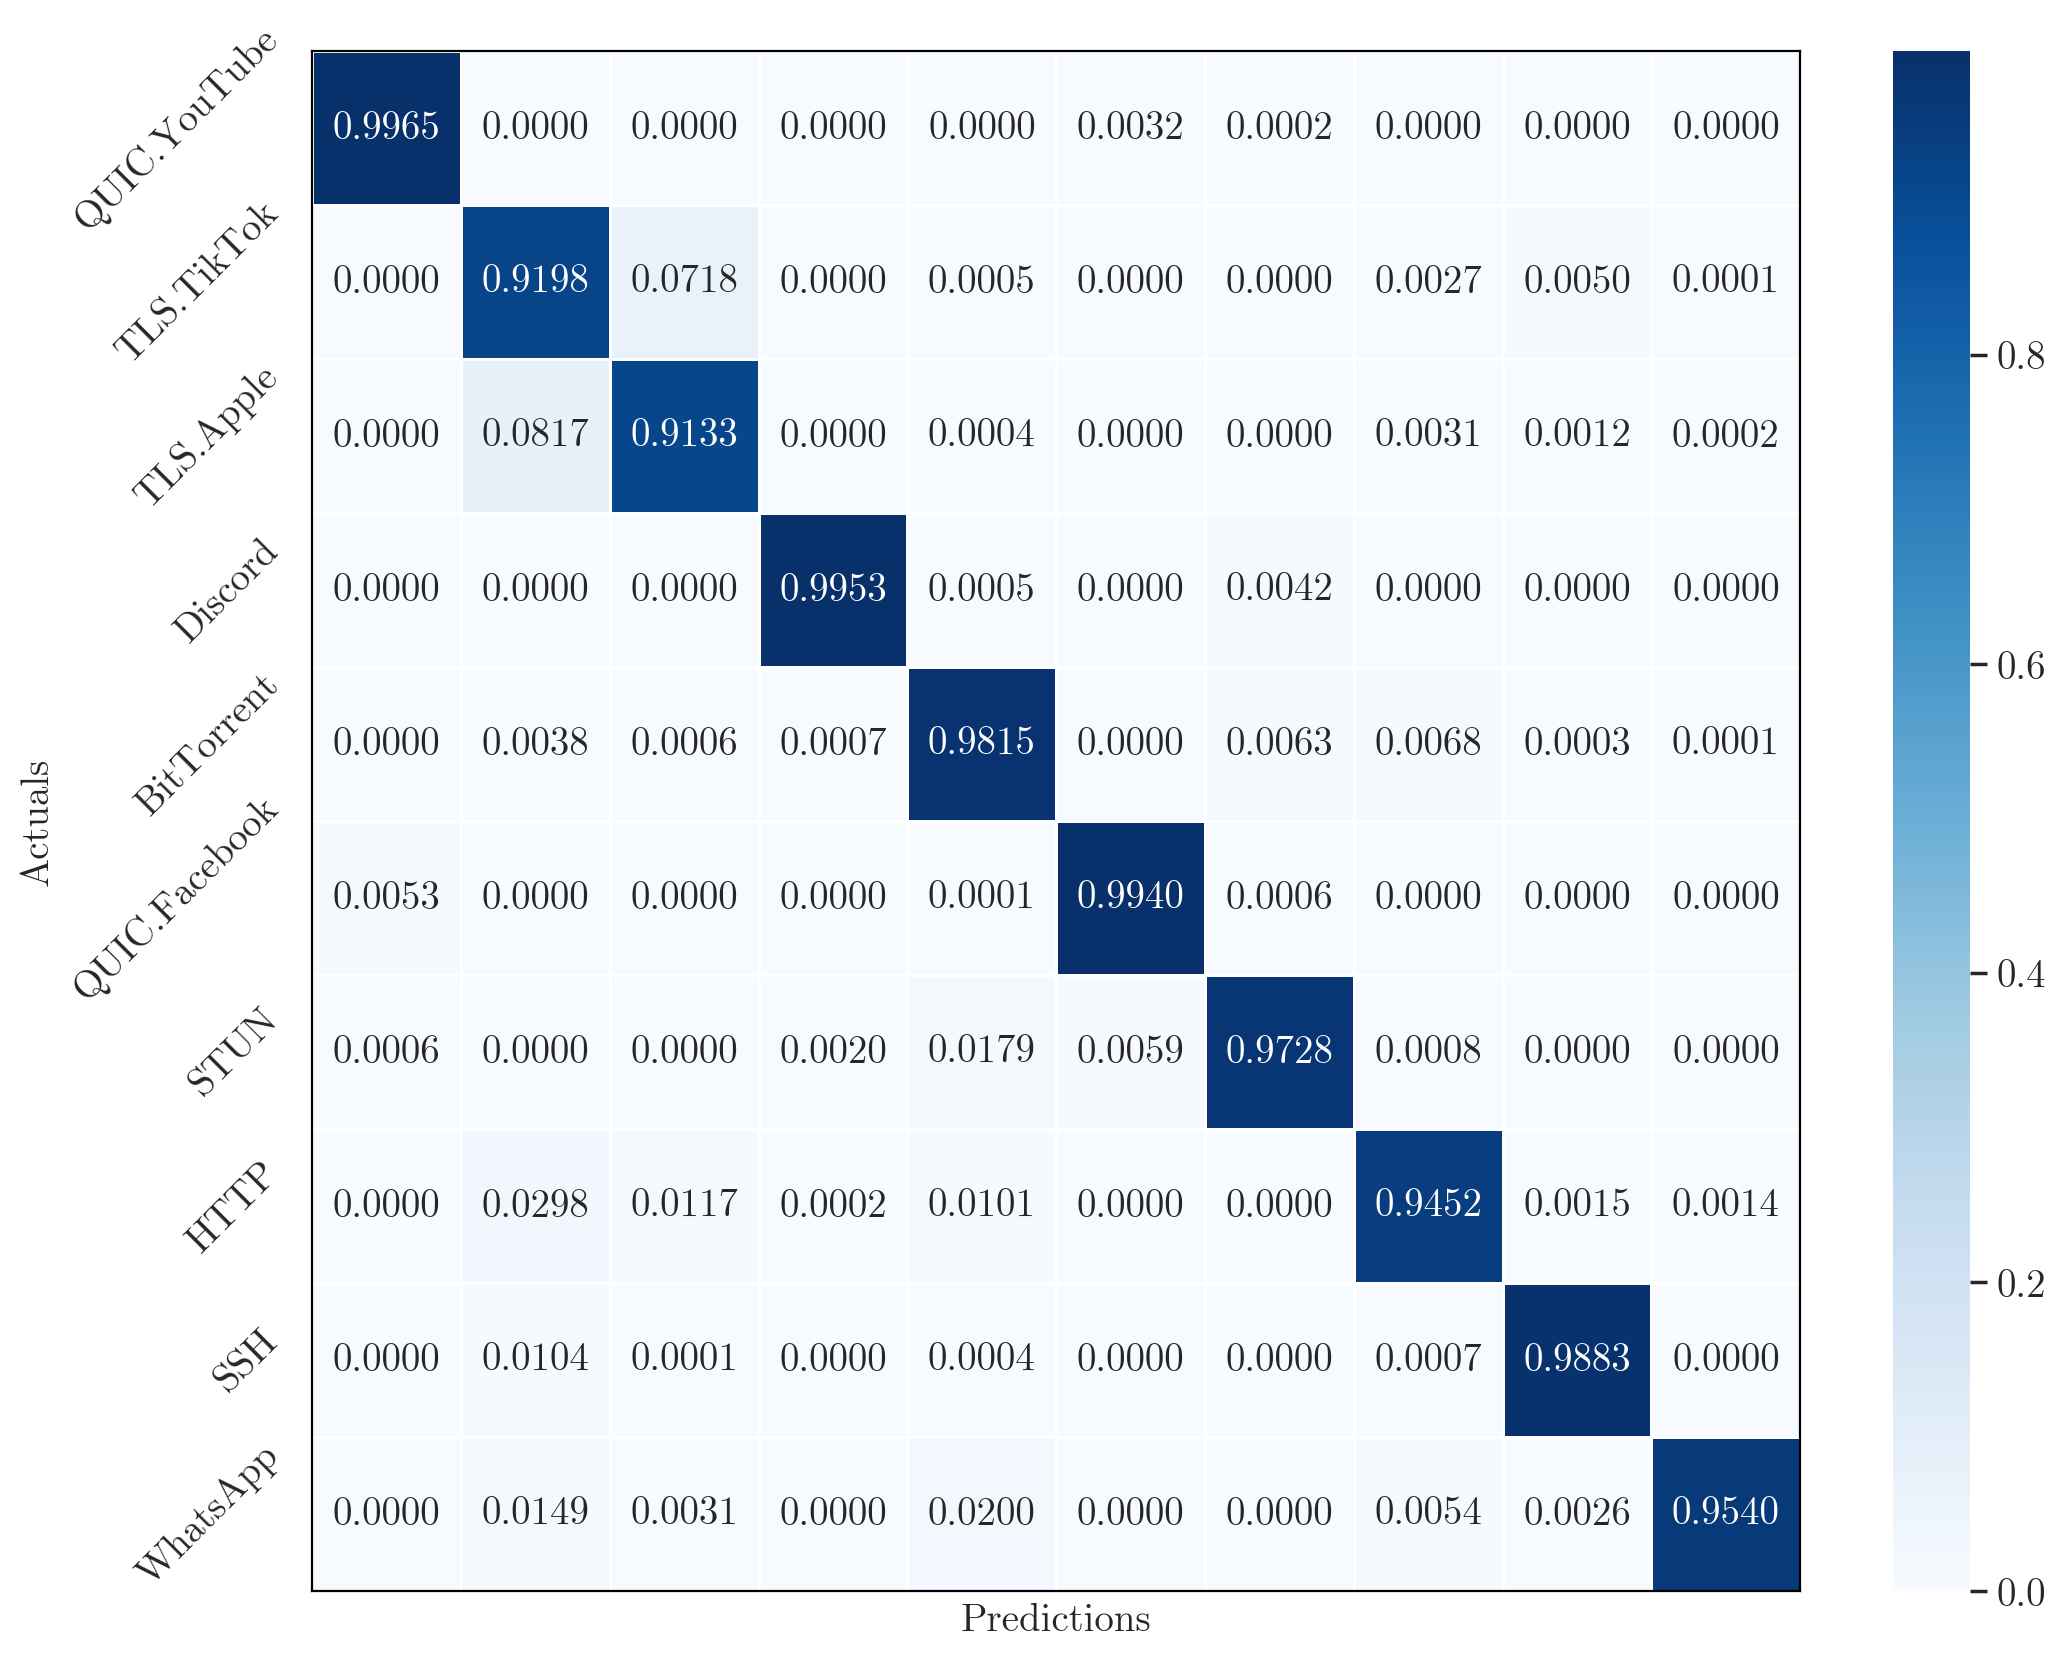

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the labels for our axes
labels = ["QUIC.YouTube", "TLS.TikTok", "TLS.Apple", "Discord", "BitTorrent",
         "QUIC.Facebook", "STUN", "HTTP", "SSH", "WhatsApp"]


# Define the confusion matrix
cl_confusion = np.array([
            [0.996531954446753, 0.0, 0.0, 0.0, 4.686548044928374e-05, 0.003186852670551294, 0.0002343274022464187, 0.0, 0.0, 0.0],
            [0.0, 0.9198058653448988, 0.07176786451879388, 0.0, 0.00053696819496076, 0.0, 0.0, 0.0027261462205700124, 0.005039239983477902, 0.00012391573729863693],
            [0.0, 0.081681550860379, 0.9133397641347979, 0.0, 0.00043563493792202136, 0.0, 0.0, 0.0031427949092945827, 0.0012446712512057753, 0.0001555839064007219],
            [0.0, 0.0, 0.0, 0.9953126723282232, 0.0004963052828940112, 0.0, 0.004191022388882762, 0.0, 0.0, 0.0],
            [0.0, 0.003786310122463468, 0.0005916109566349169, 0.0006507720522984085, 0.9815417381529906, 0.0, 0.006271076140330119, 0.006803526001301544, 0.00029580547831745845, 5.916109566349169e-05],
            [0.0052690509122044395, 0.0, 0.0, 0.0, 0.00013172627280511097, 0.9940064545873675, 0.0005927682276229994, 0.0, 0.0, 0.0],
            [0.0005554526939455656, 0.0, 0.0, 0.002036659877800407, 0.01786706165524903, 0.005924828735419367, 0.9727828179966673, 0.0008331790409183484, 0.0, 0.0],
            [0.0, 0.029815428300993846, 0.01171320397539044, 0.000236630383341221, 0.010056791292001894, 0.0, 0.0, 0.9452200662565073, 0.0015380974917179365, 0.001419782300047326],
            [0.0, 0.010388111383638725, 0.00014427932477276007, 0.0, 0.0004328379743182802, 0.0, 0.0, 0.0007213966238638004, 0.9883133746934064, 0.0],
            [0.0, 0.014927963895157092, 0.003124457559451484, 0.0, 0.01996181218538448, 0.0, 0.0, 0.005381010241277556, 0.0026037146328762367, 0.9540010414858532]
])

FSIZE = 14

# Set the font family and size
plt.rcParams['font.family'] = 'CMU Serif'
plt.rcParams['font.size'] = FSIZE

cmap = sns.color_palette("Blues", as_cmap=True)

# Function to plot a confusion matrix
def plot_confusion_matrix(confusion_matrix, plot_name):
    fig, ax = plt.subplots(figsize=(12, 10))

    heatmap = sns.heatmap(confusion_matrix
                          , annot=True
                          , fmt=".4f"
                          , linewidths=.5
                          , ax=ax
                          , cmap=cmap
                          , cbar=True
                          , rasterized=False
                          )
    
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=FSIZE)

    for spine in ax.spines.values():
        spine.set(visible=True, lw=.8, edgecolor="black")

    # Set up axes
    ax.set_xticklabels(labels, rotation=45, ha='center', fontsize=FSIZE)  # Rotate the x-axis tick labels by 45 degrees
    ax.set_yticklabels(labels, rotation=45, ha='right', fontsize=FSIZE)  # Rotate the y-axis tick labels by 45 degrees
    ax.set_xlabel('Predictions', fontsize=FSIZE)
    ax.set_ylabel('Actuals', fontsize=FSIZE)

        
    # Move the x-axis tick labels to the top
#     ax.xaxis.set_tick_params(labeltop=True, labelbottom=False)
    ax.xaxis.set_tick_params(labeltop=False, labelbottom=False)

    # Move the x-axis ticks to the top
#     ax.tick_params(axis='x', which='both', top=True, bottom=False)
    ax.tick_params(axis='x', which='both', top=False, bottom=False)
    
    # Show the plot
    plt.savefig(plot_name, dpi=300, bbox_inches='tight')
    plt.show()

plot_confusion_matrix(cl_confusion, "cm-cl.png")